<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Author: Unknown_

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [107]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [108]:
# Is there any missing data?
walmart.isnull().sum()[walmart.isnull().sum() != 0]

Series([], dtype: int64)

In [109]:
# What are the column datatypes?
walmart.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [110]:
# How many observations are there?
walmart.shape[0]

421570

In [111]:
# How many unique stores are there?
walmart['Store'].nunique()

45

In [112]:
# How many unique departments are there?
walmart['Dept'].nunique()

81

**Creating a datetime index**

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [113]:
walmart.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

In [114]:
# Convert `Date` column to datetime
walmart['Date'] = pd.to_datetime(walmart['Date'])
walmart['Date'].dtypes

dtype('<M8[ns]')

In [115]:
# Set `Date` column as index for the dataframe
walmart.set_index('Date', inplace=True)

In [116]:
# Check head of the dataframe
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [117]:
weekly_store_1 = walmart.groupby(['Store','Date']).mean().loc[1][['Weekly_Sales']]
weekly_store_1.head()

,Weekly_Sales
Date,
2010-02-05,22516.313699
2010-02-12,22804.964444
2010-02-19,22081.755753
2010-02-26,19579.549861
2010-03-05,21298.721644


In [118]:
weekly_store_1.tail()

,Weekly_Sales
Date,
2012-09-28,19685.743288
2012-10-05,23205.360694
2012-10-12,21548.942603
2012-10-19,21240.405211
2012-10-26,20745.274167


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

In [119]:
def plot_series(df, cols, title='Title', xlab=None, ylab=None):
    
    # Set figure size
    plt.figure(figsize=(15,7))
    
    # Iterate through each column name
    for col in cols:
        
        # Generate a line plot of the column name
        # You only have to specify Y, since our
        # index will automatically be the datetime index
        plt.plot(df[col],label=col)
        
    # Generate title and labels
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

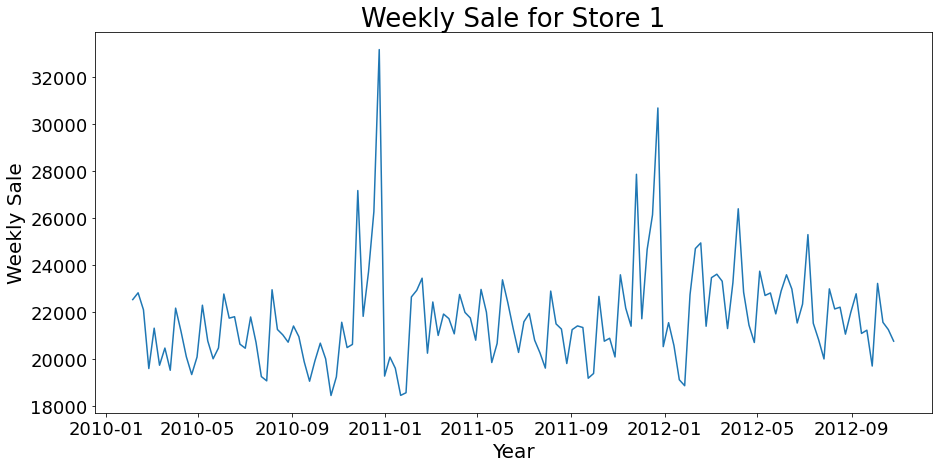

In [120]:
plot_series(weekly_store_1, cols=['Weekly_Sales'],
            title='Weekly Sale for Store 1',
            xlab='Year',
            ylab='Weekly Sale')

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

In [121]:
weekly_store_1['4_week'] = weekly_store_1['Weekly_Sales'].rolling(4).mean()
weekly_store_1['13_week'] = weekly_store_1['Weekly_Sales'].rolling(13).mean()

In [122]:
weekly_store_1.columns

Index(['Weekly_Sales', '4_week', '13_week'], dtype='object')

In [123]:
weekly_store_1.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=143, freq=None)

In [124]:
pd.to_datetime('2011-01-01')

Timestamp('2011-01-01 00:00:00')

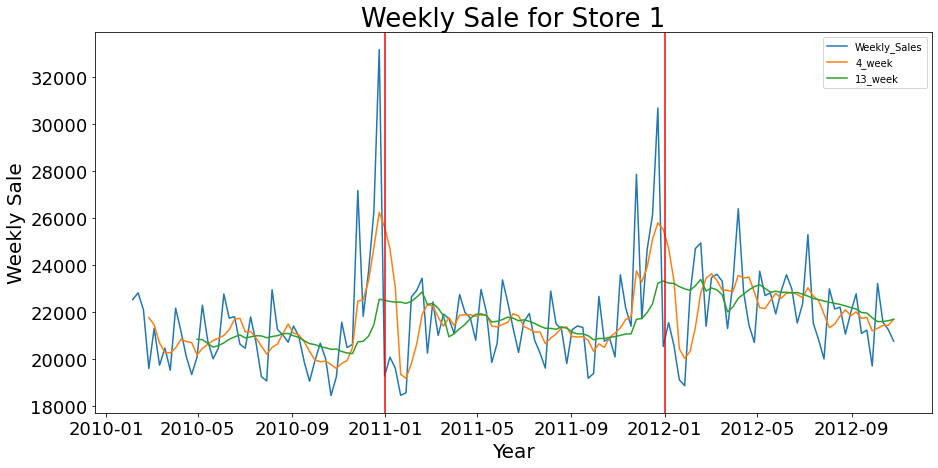

In [125]:
plot_series(weekly_store_1, cols=list(weekly_store_1.columns),
            title='Weekly Sale for Store 1',
            xlab='Year',
            ylab='Weekly Sale')
plt.axvline(x=pd.to_datetime('2011-01-01'),ymin=0,ymax=40_000, color='red')
plt.axvline(x=pd.to_datetime('2012-01-01'),ymin=0,ymax=40_000, color='red')
plt.legend();

**Describe any trends that you notice**

In [126]:
# A: 
# There are no trend in this time series dataset.

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

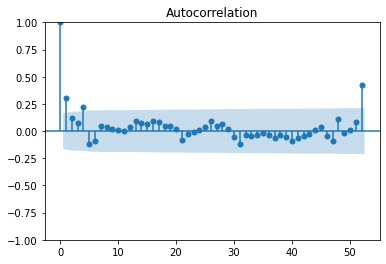

In [127]:
plot_acf(weekly_store_1['Weekly_Sales'],lags=52);

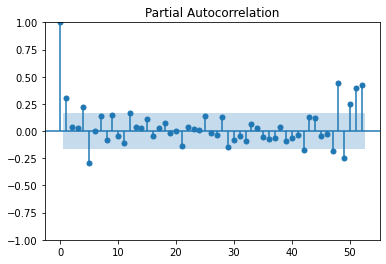

In [128]:
plot_pacf(weekly_store_1['Weekly_Sales'],lags=52);

In [129]:
# A:
# There are no trend because the small lag of autocorrelation is small value.
# This data may have seasonality based on ACF because the shape of the ACF is scallope shape.
# There are fluctuation in the time series.

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [130]:
# Split train and test
train, test = train_test_split(weekly_store_1['Weekly_Sales'],
                               test_size=0.1,
                               shuffle=False)

In [131]:
train.shape, test.shape

((128,), (15,))

In [132]:
train.head()

Date
2010-02-05    22516.313699
2010-02-12    22804.964444
2010-02-19    22081.755753
2010-02-26    19579.549861
2010-03-05    21298.721644
Name: Weekly_Sales, dtype: float64

In [133]:
train.tail()

Date
2012-06-15    22966.295775
2012-06-22    21518.955070
2012-06-29    22324.949130
2012-07-06    25283.630857
2012-07-13    21507.240000
Name: Weekly_Sales, dtype: float64

In [134]:
test.head()

Date
2012-07-20    20804.927222
2012-07-27    19987.829306
2012-08-03    22973.743521
2012-08-10    22116.805139
2012-08-17    22192.611806
Name: Weekly_Sales, dtype: float64

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [135]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], 
                         index=['Test Statistic','p-value'])
    return dfoutput

In [136]:
interpret_dftest(adfuller(train))

Test Statistic   -4.852298
p-value           0.000043
dtype: float64

In [137]:
# Test statistic is large negative value and p-value is small value.
# We reject the hypothesis.
# The time series is stationary.

---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [138]:
arima = ARIMA(endog=train, order=(1,0,0))
model = arima.fit()

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data.

In [139]:
pred_train = model.predict(start=train.index[0], end=train.index[-1])
pred_test = model.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Use the `mean_squared_error` function to identify the MSE on the testing data.

In [140]:
mean_squared_error(test, pred_test)

1034919.8963228014

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

In [141]:
def weekly_sales_graph(train,pred_train,test,pred_test):
    plt.figure(figsize=(15,8))
    plt.plot(train, label='train', color='royalblue')
    plt.plot(pred_train, label='train prediction',color='cyan')
    plt.plot(test, label='test',color='salmon')
    plt.plot(pred_test, label='test predtiction', color='orange')
    plt.title('Weekly Sales for Store 1', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Weekly Sales', fontsize=15)
    plt.legend();

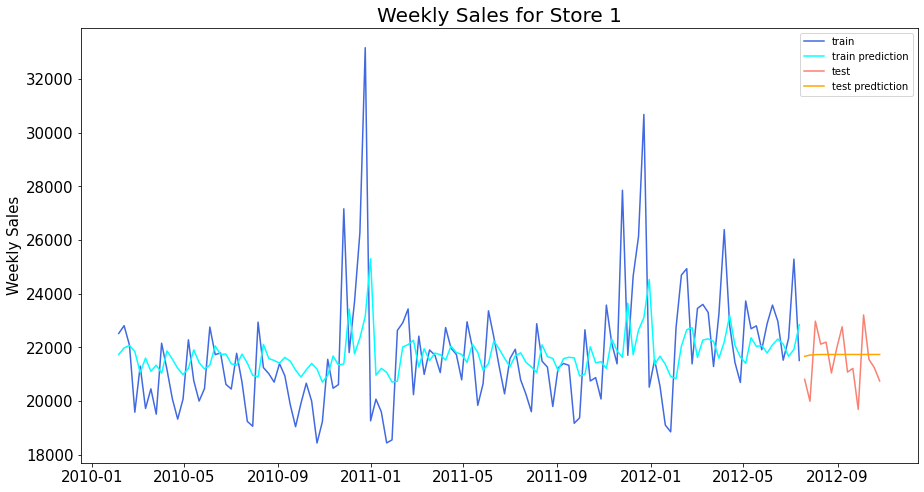

In [142]:
weekly_sales_graph(train,pred_train,test,pred_test)

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

The model performs poorly. The model just predict the mean of the time series.

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [143]:
arima = ARIMA(endog=train, order=(2,0,2))
model = arima.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [144]:
pred_train = model.predict(start=train.index[0], end=train.index[-1])
pred_test = model.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [145]:
mean_squared_error(test, pred_test)

1078462.0512366781

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

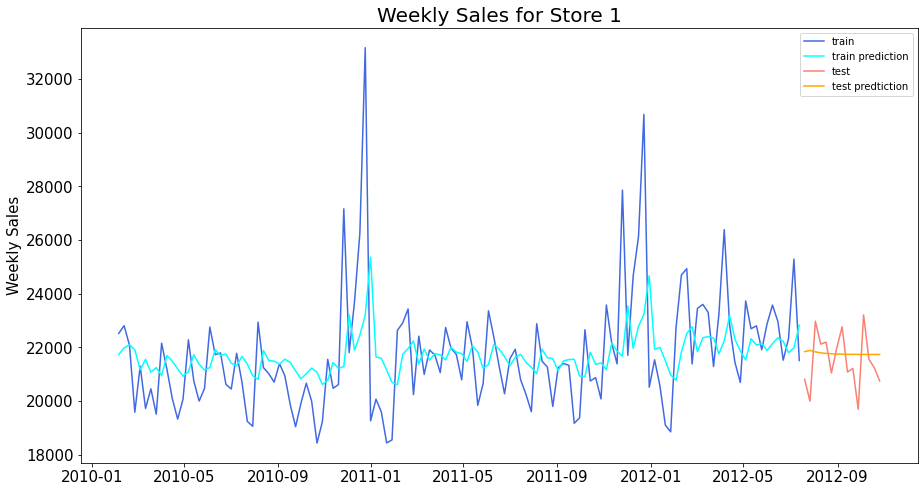

In [146]:
weekly_sales_graph(train,pred_train,test,pred_test)

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [147]:
# A: 
# The model performs poorly like ARIMA(1,0,0)

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [148]:
arima = ARIMA(endog=train, order=(2,1,2))
model = arima.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [149]:
pred_train = model.predict(start=train.index[0], end=train.index[-1])
pred_test = model.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [150]:
mean_squared_error(test, pred_test)

2046226.7334365912

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

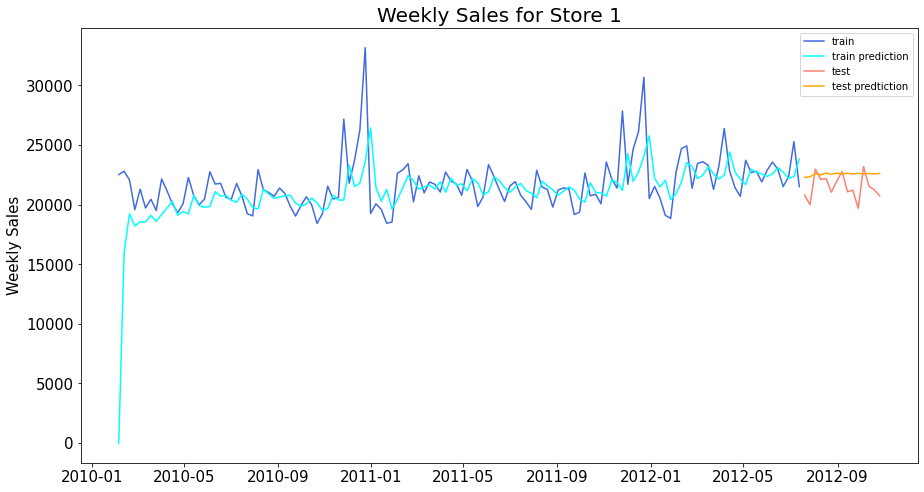

In [151]:
weekly_sales_graph(train,pred_train,test,pred_test)

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [152]:
# A:
# The model performs poorly.
# High MSE

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [153]:
arima = ARIMA(endog=train, order=(52,0,1))
model = arima.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [154]:
pred_train = model.predict(start=train.index[0], end=train.index[-1])
pred_test = model.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [155]:
mean_squared_error(test, pred_test)

1013343.5230266218

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

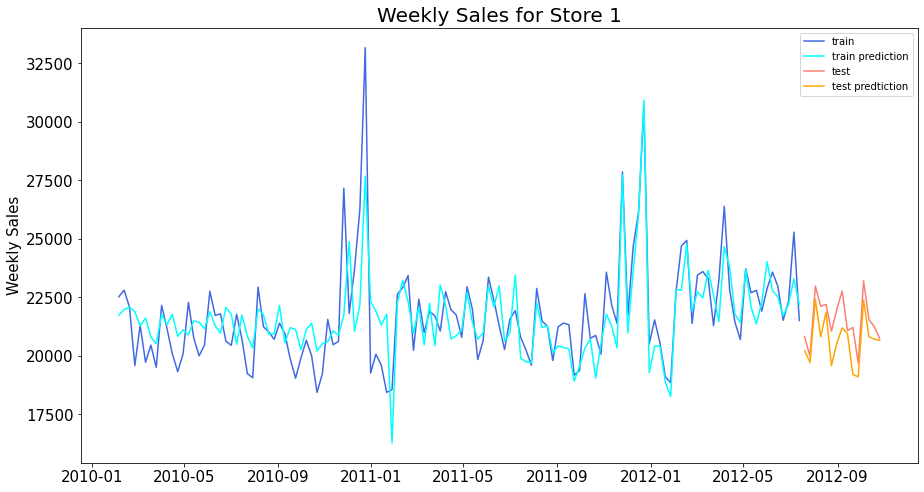

In [156]:
weekly_sales_graph(train,pred_train,test,pred_test)

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [157]:
# A: 
# The model performs much better than previous model
# because the prediction from the model isn't just predicting the mean of the data

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

MSE: 529489.6437179836


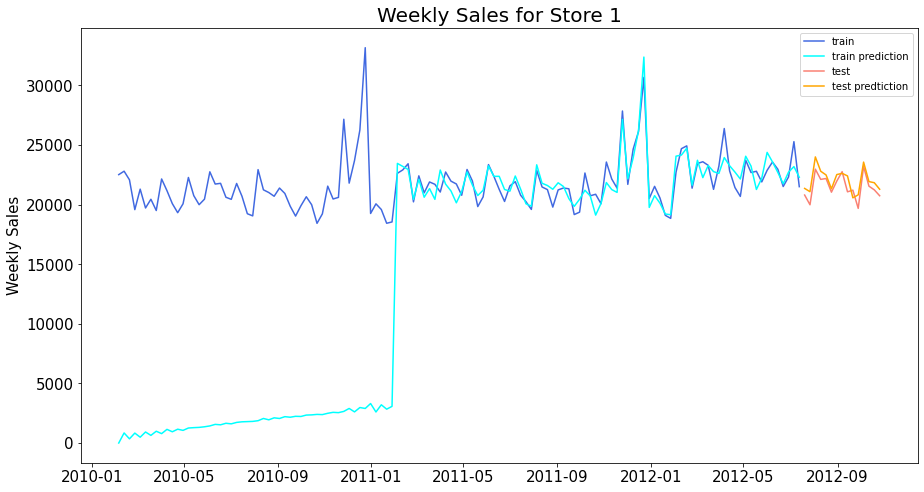

In [158]:
sarima = ARIMA(endog=train, order=(2,0,2),
               seasonal_order=(1,1,1,52))
model = sarima.fit()
pred_train = model.predict(start=train.index[0], end=train.index[-1])
pred_test = model.predict(start=test.index[0], end=test.index[-1])
print(f'MSE: {mean_squared_error(test, pred_test)}')
weekly_sales_graph(train,pred_train,test,pred_test)